# Outline
1. Comment-tree morphology (w.r.t. sentiment later)
    - depth profile
    - branching factor
    - shape imbalance
    - DO not ahole answer more than ntahole 
2. User-interaction network
    - Measures: assortativity, clustering coefficient, betweenness centrality
    - community detection: YTA-leaning vs NTA-leaning (Louvain)

# Imports & Setup

In [21]:
import numpy as np
import pandas as pd
import networkx as nx
import statistics
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm
import os
import json
import math
import praw
import time
from praw.models import MoreComments
from prawcore.exceptions import TooManyRequests

In [3]:
def plot_graph(G, title):
    plt.figure(figsize=(20, 20))
    nx.draw_spring(
        G,
        node_size=40,
        with_labels=False,
        edge_color='gray'
    )
    plt.title(title)
    plt.axis('off')
    plt.show()

In [4]:
with open("../redditCredentials.json", "r") as f:
    credentials = json.load(f)

reddit = praw.Reddit(client_id=credentials['CLIENT_ID'],
                     client_secret=credentials['SECRET_TOKEN'],
                     password=credentials['PASSWORD'],
                     user_agent='AITA-analysis',
                     username=credentials['USERNAME'],
                     check_for_async=False)

# Building Reply Graphs

## Defining Functions and preparing Submission IDS

In [5]:
df = pd.read_csv('top450-aita-balanced.csv')

subset_20_A_Hole = (
    df.loc[df["link_flair_text"] == "Asshole"]
    .sample(n=20, random_state=42) 
)

subset_20_NTA_Hole = (
    df.loc[df["link_flair_text"] == "Not the A-hole"]
    .sample(n=20, random_state=42) 
)

In [6]:
def build_author_reply_graph(submission_id: str, reddit: praw.Reddit):

    subm = reddit.submission(id=submission_id)
    subm.comments.replace_more(limit=None)

    edges = []
    stack = collections.deque(
        (subm.author, top)
        for top in subm.comments
    )

    while stack:
        parent_author, comment = stack.pop()

        if parent_author is None or comment.author is None:
            pass
        else:
            src = str(parent_author)
            tgt = str(comment.author)
            edges.append((src, tgt))
        for child in comment.replies:
            stack.append((comment.author, child))

    return edges

def build_authorID_reply_graph(submission_id: str, reddit: praw.Reddit):

    subm = reddit.submission(id=submission_id)
    subm.comments.replace_more(limit=None)

    edges = []
    stack = collections.deque(
        (subm.author, top)
        for top in subm.comments
    )

    while stack:
        parent_author, comment = stack.pop()

        if parent_author is None or comment.author is None:
            pass
        else:
            src = str(parent_author)
            tgt = str(comment.author)
            edges.append((src, tgt))
        for child in comment.replies:
            stack.append((comment.author, child))

    return edges

import collections

def build_combined_reply_graph(submission_id: str, reddit: praw.Reddit):
    """
    Traverse all comments in a submission and collect edges that contain:
      - parent comment ID (or submission ID for top‐level)
      - child comment ID
      - parent author username (or None if deleted)
      - child author username (or None if deleted)
    Returns a list of tuples:
      (parent_id, child_id, parent_author, child_author)
    """
    subm = reddit.submission(id=submission_id)
    subm.comments.replace_more(limit=None)

    edges = []
    # Initialize stack: for each top‐level comment, parent_id = submission ID, parent_author = submission author
    stack = collections.deque(
        (subm.id, subm.author, top) 
        for top in subm.comments
    )

    while stack:
        parent_id, parent_author, comment = stack.pop()

        child_id = comment.id
        child_author = comment.author

        # Convert authors to strings (or keep None if deleted)
        parent_author_str = str(parent_author) if parent_author is not None else None
        child_author_str = str(child_author) if child_author is not None else None

        # Record the edge (IDs + authors). Even if an author is None, the IDs may still be useful later.
        edges.append((parent_id, child_id, parent_author_str, child_author_str))

        # Push each reply onto the stack, setting parent to this comment
        for reply in comment.replies:
            stack.append((comment.id, comment.author, reply))

    return edges


## Gathering Data

In [98]:
### A-Hole

for i, submission_id in enumerate(tqdm(subset_20_A_Hole["id"], desc="Building reply graphs")):

    output_path = f"replyGraphs/reply_graph-submission_{submission_id}_AHole.csv"
    if os.path.exists(output_path):
        continue
    
    retries = 0

    while True:
        try:
            edges = build_combined_reply_graph(submission_id, reddit)
            break
        except TooManyRequests:
            retries += 1
            backoff = min(60 * retries, 300)
            print(f"429 on {submission_id}: sleeping {backoff} seconds (retry #{retries})")
            time.sleep(backoff)
        except Exception as e:
            print(f"Error on {submission_id}: {e}. Skipping this submission.")
            edges = []
            break

    if edges:
        df = pd.DataFrame(
            edges,
            columns=['parent_id', 'child_id', 'parent_author', 'child_author']
        )
        df.to_csv(f"replyGraphs/reply_graph-submission_{submission_id}_AHole.csv", index=False)

    time.sleep(5)

Building reply graphs:   0%|          | 0/20 [00:00<?, ?it/s]

Building reply graphs:  70%|███████   | 14/20 [12:16<08:06, 81.15s/it]

429 on cdypge: sleeping 60 seconds (retry #1)


Building reply graphs: 100%|██████████| 20/20 [38:12<00:00, 114.60s/it]


In [7]:
### Not The A-Hole

for i, submission_id in enumerate(tqdm(subset_20_NTA_Hole["id"], desc="Building reply graphs")):

    output_path = f"replyGraphs/reply_graph-submission_{submission_id}_NTAHole.csv"
    if os.path.exists(output_path):
        continue
    
    retries = 0

    while True:
        try:
            edges = build_combined_reply_graph(submission_id, reddit)
            break
        except TooManyRequests:
            retries += 1
            backoff = min(60 * retries, 300)
            print(f"429 on {submission_id}: sleeping {backoff} seconds (retry #{retries})")
            time.sleep(backoff)
        except Exception as e:
            print(f"Error on {submission_id}: {e}. Skipping this submission.")
            edges = []
            break

    if edges:
        df = pd.DataFrame(
            edges,
            columns=['parent_id', 'child_id', 'parent_author', 'child_author']
        )
        df.to_csv(f"replyGraphs/reply_graph-submission_{submission_id}_NTAHole.csv", index=False)

    time.sleep(5)

Building reply graphs:   0%|          | 0/20 [00:00<?, ?it/s]

Building reply graphs: 100%|██████████| 20/20 [03:55<00:00, 11.79s/it]


In [8]:
### Reading from CSV

folder_path = "replyGraphs"
rel_AHole = dict()
rel_NTAHole = dict()

for filename in os.listdir(folder_path):
    if filename.endswith("_AHole.csv"):
        file_path = os.path.join(folder_path, filename)
        rel_AHole[file_path[35:41]]=pd.read_csv(file_path)
    if filename.endswith("_NTAHole.csv"):
        file_path = os.path.join(folder_path, filename)
        rel_NTAHole[file_path[35:41]]=pd.read_csv(file_path)

## Example of NTA Graph and YTA Graph

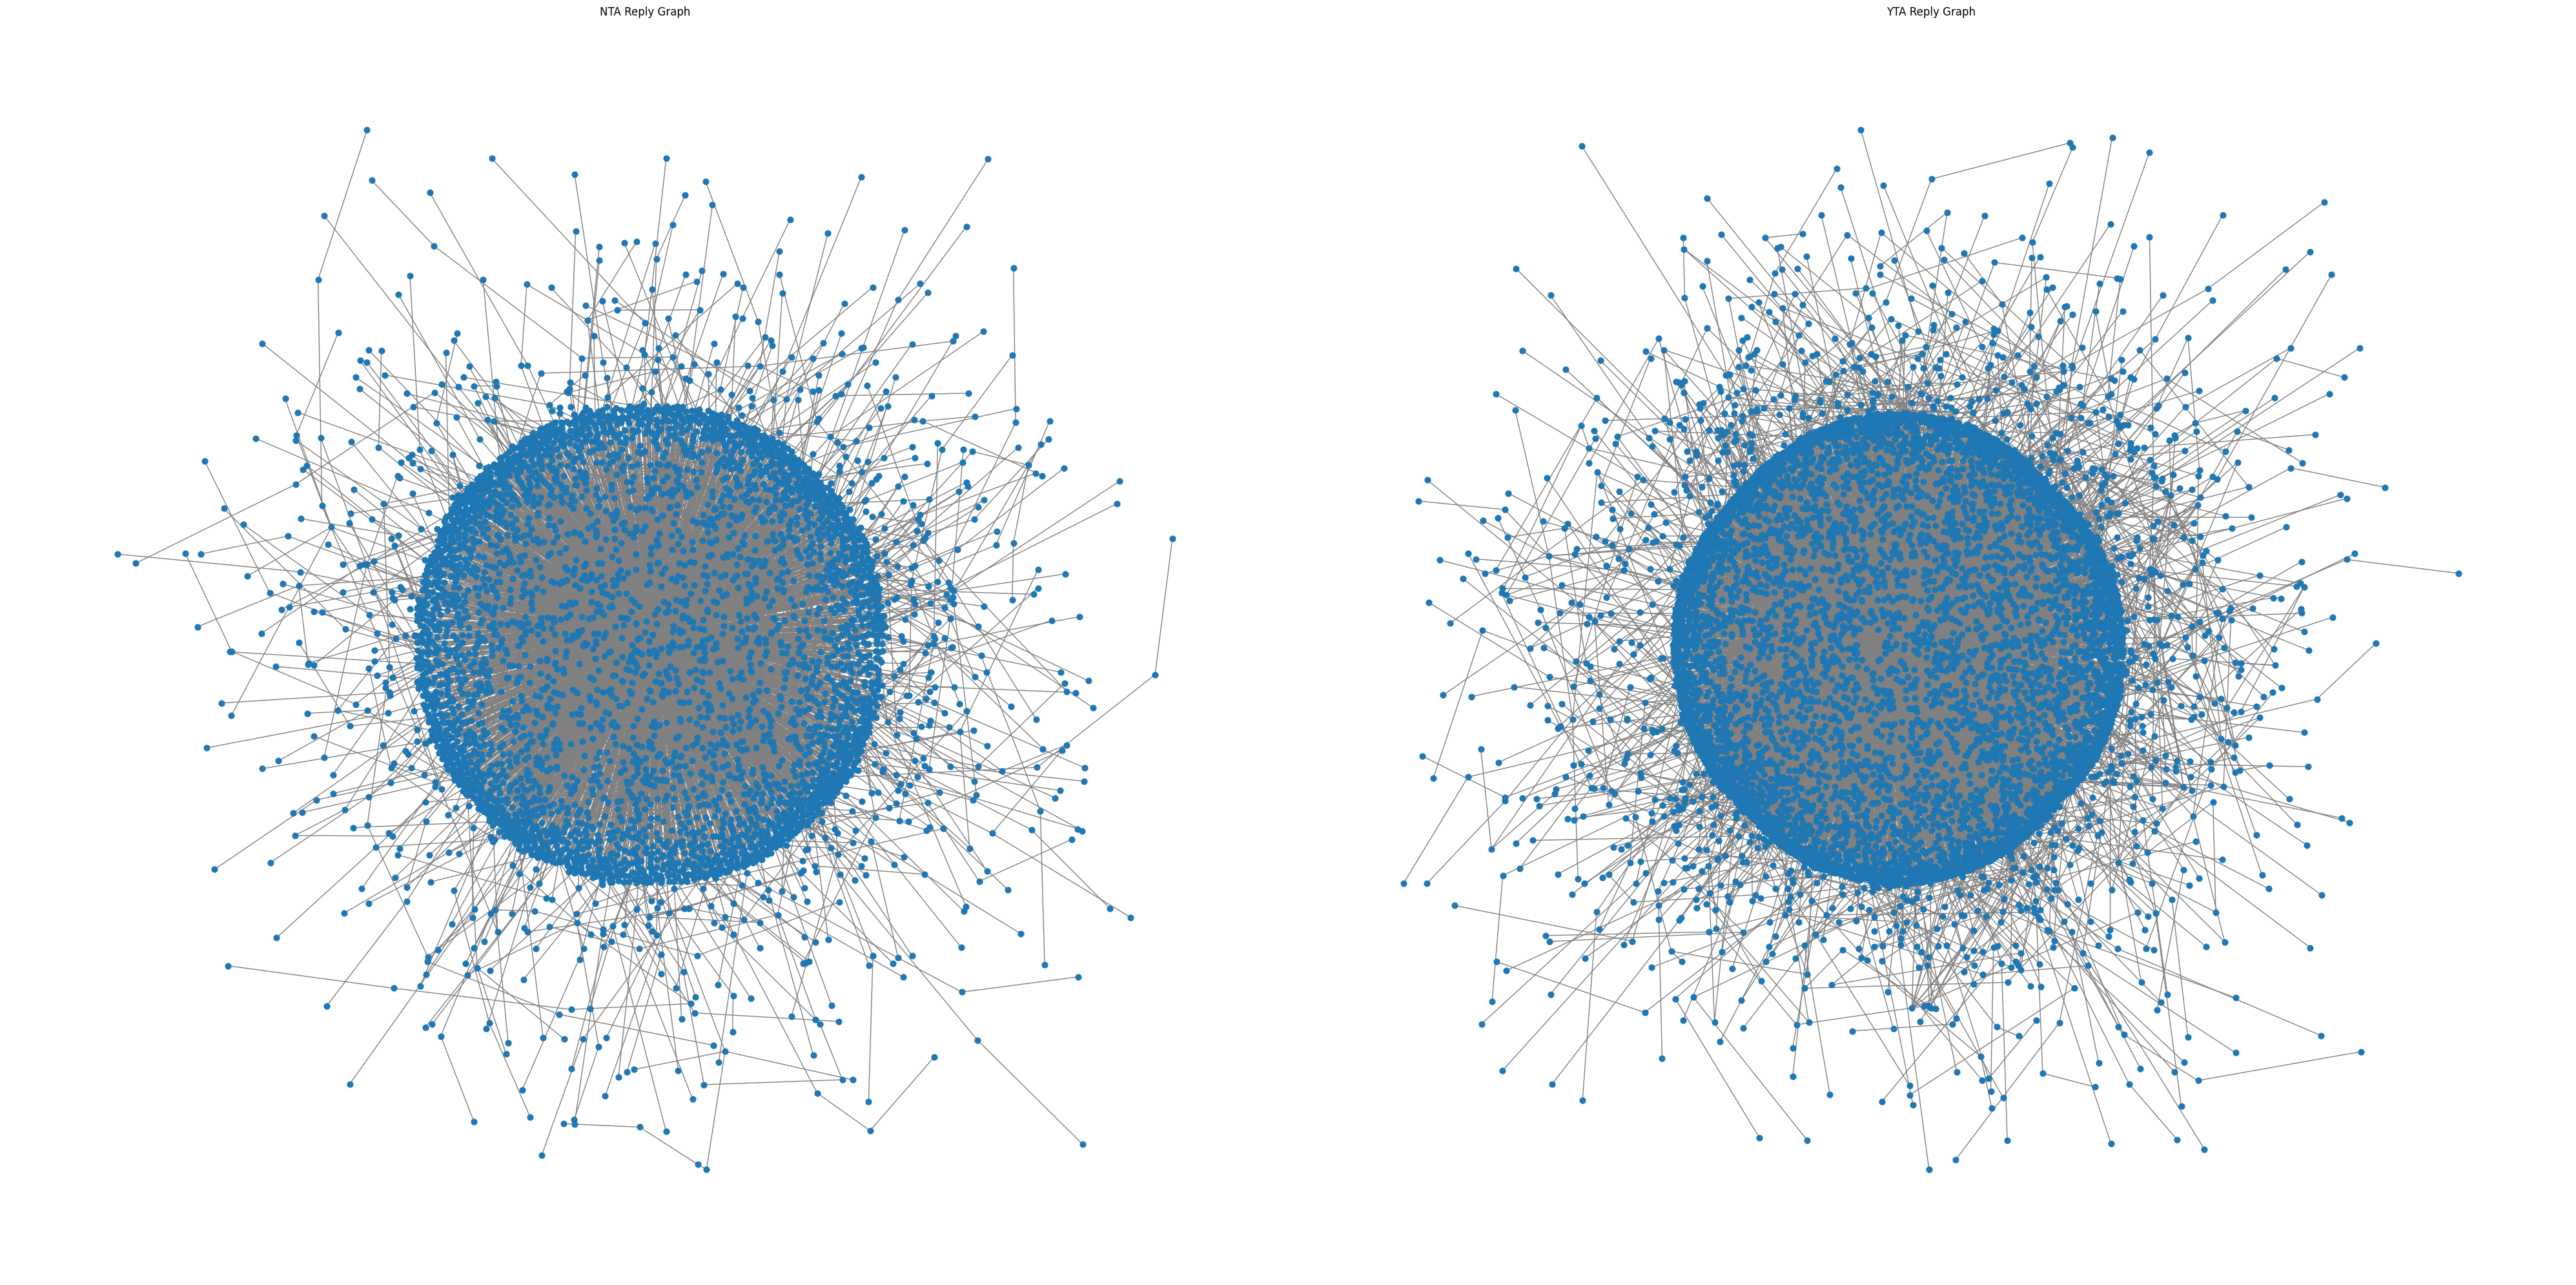

In [10]:
df_NTA = list(rel_NTAHole.values())[3]
df_YTA = list(rel_AHole.values())[5]

# Create two empty graphs
G_NTA = nx.Graph()
G_YTA = nx.Graph()

# Populate the NTA graph
for _, row in df_NTA.iterrows():
    G_NTA.add_edge(row['parent_id'], row['child_id'])

# Populate the YTA graph
for _, row in df_YTA.iterrows():
    G_YTA.add_edge(row['parent_id'], row['child_id'])

# Create a figure with 1×2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 20))

# Draw the NTA graph in the left subplot
nx.draw_spring(
    G_NTA,
    ax=ax1,
    node_size=40,
    with_labels=False,
    edge_color='gray'
)
ax1.set_title("NTA Reply Graph")

# Draw the YTA graph in the right subplot
nx.draw_spring(
    G_YTA,
    ax=ax2,
    node_size=40,
    with_labels=False,
    edge_color='gray'
)
ax2.set_title("YTA Reply Graph")

plt.tight_layout()
plt.show()


# Morphology Analysis

In [11]:
G_NTA_dict = {}
G_YTA_dict = {}

for submission_id, df_edges in rel_NTAHole.items():
    G = nx.DiGraph()
    for _, row in df_edges.iterrows():
        G.add_edge(row['parent_id'], row['child_id'])
    G_NTA_dict[submission_id] = G

for submission_id, df_edges in rel_AHole.items():
    G = nx.DiGraph()
    for _, row in df_edges.iterrows():
        G.add_edge(row['parent_id'], row['child_id'])
    G_YTA_dict[submission_id] = G

## Depth, Branching and Shape Imbalance Analysis

In [56]:
def compute_reply_graph_stats(G_dict):
    """
    For each submission-ID → reply-graph (a directed graph where the submission node is the only root),
    compute:
      - number_of_nodes: total number of nodes in G
      - max_depth:      longest chain of replies from the root
      - avg_depth:      average depth (hops from the root)
      - median_depth:   median of all node depths
      - percent_deeper_3: percentage of nodes with depth > 3
      - percent_deeper_5: percentage of nodes with depth > 5
      - percent_deeper_7: percentage of nodes with depth > 7
      - avg_branching:  average number of replies for any comment that has ≥1 reply (excluding the node with max out-degree)
      - max_branching:  maximum number of direct replies under any single comment (excluding the node with max out-degree)
      - shape_imbalance: S / (n * log2(n)), where S = sum(depth[v] for all leaves v)
    """
    rows = []
    for submission_id, G in G_dict.items():
        # Identify the root: the node with in_degree == 0
        roots = [n for n, d in G.in_degree() if d == 0]
        root = roots[0]
        assert root is not None

        # ___________Depth_Measures________________
        dist = nx.single_source_shortest_path_length(G, root)
        depth_vals = list(dist.values())

        max_depth = max(depth_vals)
        avg_depth = sum(depth_vals) / len(depth_vals)
        median_depth = statistics.median(depth_vals)

        percent_deeper = {}
        for k in (3, 5, 7):
            count_deeper = sum(1 for d in depth_vals if d > k)
            percent_deeper[k] = 100.0 * count_deeper / len(depth_vals)

        # ___________Branching_Measures____________________
        # Collect out-degrees for all nodes that have at least one child
        child_counts = [G.out_degree(n) for n in G.nodes() if G.out_degree(n) > 0]

        # Remove the maximum out-degree once to exclude the single largest branching node
        # (often the root) from the "average branching" calculation
        if child_counts:
            max_val = max(child_counts)
            child_counts.remove(max_val)

        if child_counts:
            avg_branch = sum(child_counts) / len(child_counts)
            max_branch = max(child_counts)
        else:
            avg_branch = 0
            max_branch = 0

        # ___________Shape_Imbalance_____________________
        # Compute shortest-path lengths from root to every node
        depth = nx.single_source_shortest_path_length(G, root)
        # Identify leaves: nodes with out_degree == 0
        leaves = [v for v in G.nodes() if G.out_degree(v) == 0]
        S = sum(depth[v] for v in leaves)
        n = G.number_of_nodes()
        shape_imbalance = S / (n * math.log2(n) if n > 1 else 1)

        rows.append({
            "submission_id": submission_id,
            "number_of_nodes": G.number_of_nodes(),
            "max_depth": max_depth,
            "avg_depth": avg_depth,
            "median_depth": median_depth,
            "percent_deeper_3": percent_deeper[3],
            "percent_deeper_5": percent_deeper[5],
            "percent_deeper_7": percent_deeper[7],
            "avg_branching": avg_branch,
            "max_branching": max_branch,
            "shape_imbalance": shape_imbalance
        })

    return pd.DataFrame(rows)

# Example usage:
metrics_NTA = compute_reply_graph_stats(G_NTA_dict)
metrics_YTA = compute_reply_graph_stats(G_YTA_dict)

metrics_NTA.to_csv("metrics_NTA.csv", index=False)
metrics_YTA.to_csv("metrics_YTA.csv", index=False)

In [60]:
metrics_NTA.head()

,submission_id,number_of_nodes,max_depth,avg_depth,median_depth,percent_deeper_3,percent_deeper_5,percent_deeper_7,avg_branching,max_branching,shape_imbalance
0,daglhs,4028,23,3.023337,1.0,30.685204,18.123138,9.210526,2.162383,97,0.152616
1,wp874j,1750,18,2.532571,1.0,24.285714,12.171429,5.257143,2.157270,25,0.164642
2,1087lb,7628,15,2.067383,1.0,16.413214,8.127950,3.959098,2.423913,113,0.120463
3,vnl1hw,4495,25,2.457175,1.0,22.580645,12.903226,6.295884,2.149740,88,0.138313
4,f3asns,2651,12,1.754055,1.0,11.769144,5.394191,2.225575,1.737662,16,0.113341


In [58]:
metrics_YTA.describe()

,number_of_nodes,max_depth,avg_depth,median_depth,percent_deeper_3,percent_deeper_5,percent_deeper_7,avg_branching,max_branching,shape_imbalance
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,4889.050000,22.500000,2.972549,1.750000,28.446559,16.538660,9.102304,2.054764,82.350000,0.147204
std,2560.987525,8.708737,1.004566,0.966546,13.108983,9.954054,6.999354,0.263327,32.653323,0.028703
min,693.000000,11.000000,1.688018,1.000000,10.667316,4.724793,1.242085,1.735736,24.000000,0.109470
25%,2920.250000,15.250000,2.266233,1.000000,19.500997,9.689427,3.989727,1.873484,64.000000,0.124860
50%,4665.500000,23.000000,2.466782,1.000000,22.221525,11.856644,5.796627,1.997514,88.500000,0.143558
75%,6212.500000,29.250000,3.798969,2.250000,38.704393,24.584381,14.861386,2.164021,100.750000,0.161655
max,9724.000000,37.000000,5.217288,4.000000,55.091770,37.951451,23.741859,2.655118,145.000000,0.201081


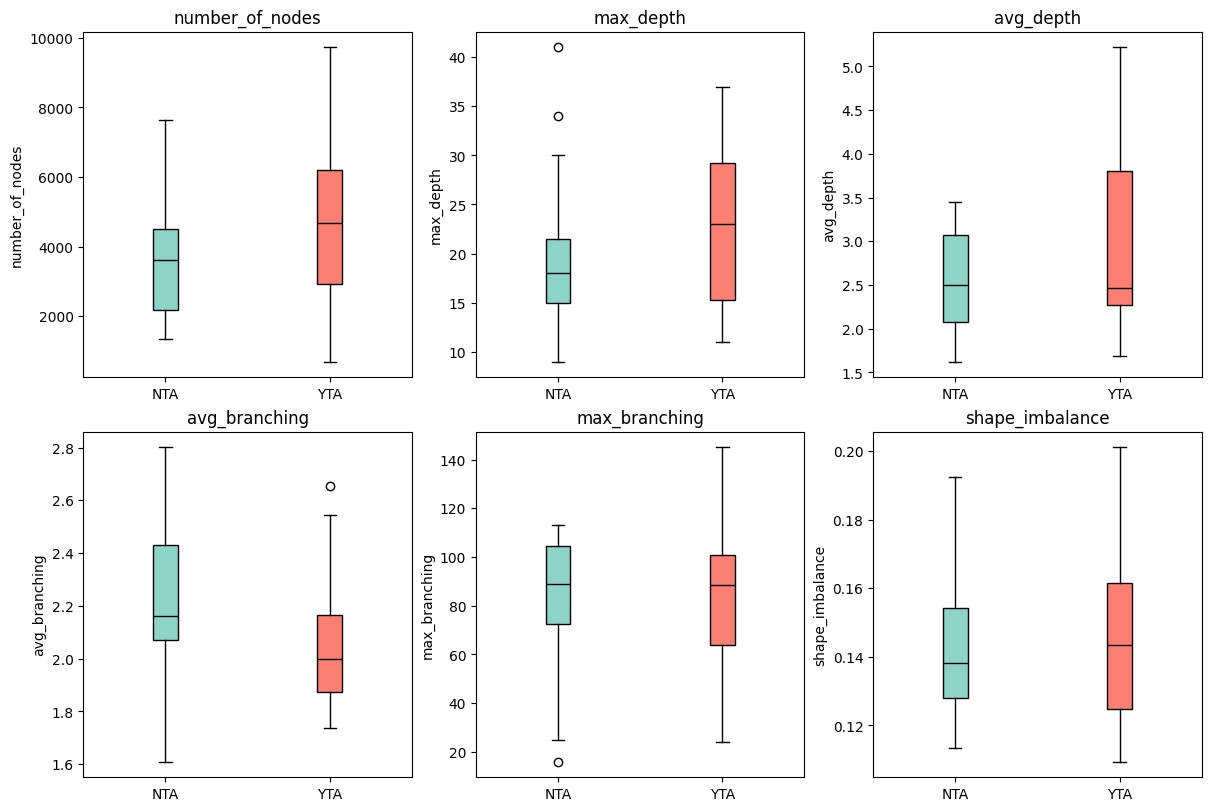

In [67]:
import matplotlib.pyplot as plt

metrics_list = [
    'number_of_nodes',
    'max_depth',
    'avg_depth',
    'avg_branching',
    'max_branching',
    'shape_imbalance'
]

# Create a 2×3 grid of subplots with a smaller figure size
fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(12, 8),
    constrained_layout=True
)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Choose two distinct, pleasant colors for NTA and YTA
colors = ['#8dd3c7', '#fb8072']  # soft green and soft salmon

for ax, metric in zip(axes, metrics_list):
    # Extract values (no NaNs to drop)
    nta_vals = metrics_NTA[metric].values
    yta_vals = metrics_YTA[metric].values

    data = [nta_vals, yta_vals]

    # Draw the boxplot with patch_artist=True so we can set individual box colors
    bp = ax.boxplot(
        data,
        patch_artist=True,
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(markeredgecolor='black')
    )

    # Apply colors to each box
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')

    # Use tick_labels instead of the 'labels' parameter
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['NTA', 'YTA'])

    ax.set_title(metric)
    ax.set_ylabel(metric)

plt.show()


## OP presence analysis

Higher Rᵒᵖ or ρᵒᵖ in YTA? → OP argues back more when being judged “the asshole.”

Lower d̄ᵒᵖ in NTA? → OP’s replies stay near the surface (quick clarifications) when absolved.

In [61]:
def compute_op_presence(graph_dict):
    """
    Returns for each submission:
      op_reply_count   : number of OP replies
      op_reply_ratio   : OP replies / total comments
      op_average_depth : mean depth of OP replies
    """
    rows = []

    for sid, edges in graph_dict.items():
        G = nx.DiGraph()

        #________build_graph________
        for _, r in edges.iterrows():
            G.add_edge(r.parent_id, r.child_id)
            if pd.notna(r.parent_author):
                G.nodes[r.parent_id]["author"] = r.parent_author
            if pd.notna(r.child_author):
                G.nodes[r.child_id]["author"] = r.child_author

        #________identify_root_op________
        root = next(n for n in G if G.in_degree(n) == 0)
        op_author = G.nodes[root].get("author")

        #________collect_op_nodes________
        op_nodes = [n for n in G if n != root and G.nodes[n].get("author") == op_author]
        op_reply_count = len(op_nodes)
        op_reply_ratio = op_reply_count / (G.number_of_nodes() - 1) if G.number_of_nodes() > 1 else 0

        #________compute_depth________
        depths = nx.shortest_path_length(G, root)
        op_average_depth = np.mean([depths[n] for n in op_nodes]) if op_reply_count else np.nan

        rows.append({
            "submission_id": sid,
            "op_reply_count": op_reply_count,
            "op_reply_ratio": op_reply_ratio,
            "op_average_depth": op_average_depth
        })

    return pd.DataFrame(rows)

op_metrics_NTA = compute_op_presence(rel_NTAHole)
op_metrics_YTA = compute_op_presence(rel_AHole)
op_metrics_NTA.to_csv("op_presence_NTA.csv", index=False)
op_metrics_YTA.to_csv("op_presence_YTA.csv", index=False)


In [77]:
print(f"Number of submission without OP replies:\nNTA: {sum(op_metrics_NTA["op_reply_count"] == 0)}\nYTA: {sum(op_metrics_YTA["op_reply_count"] == 0)}")

Number of submission without OP replies:
NTA: 2
YTA: 9


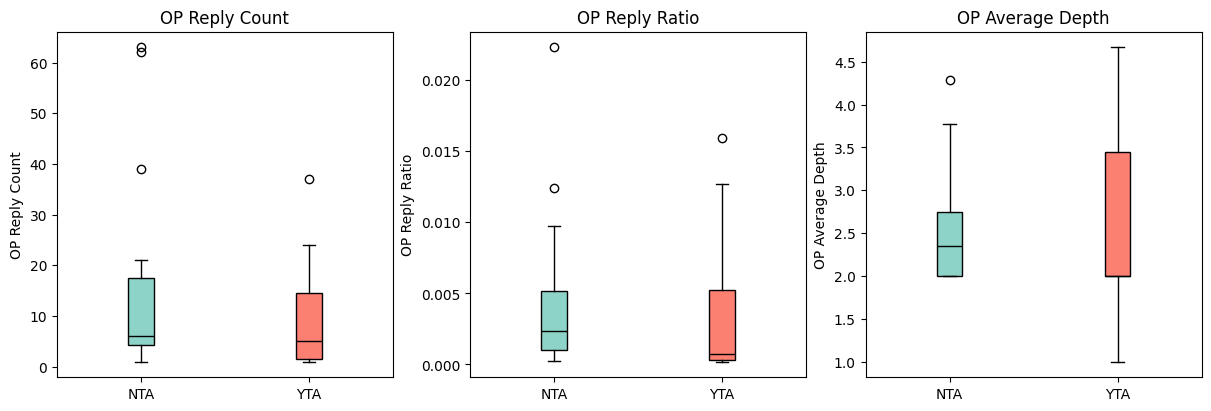

In [78]:
filtered_NTA = op_metrics_NTA[op_metrics_NTA.op_reply_count > 0]
filtered_YTA = op_metrics_YTA[op_metrics_YTA.op_reply_count > 0]

metrics = [
    ("op_reply_count",  "OP Reply Count"),
    ("op_reply_ratio",  "OP Reply Ratio"),
    ("op_average_depth","OP Average Depth")
]

fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(12, 4),
    constrained_layout=True
)

# pleasant NTA / YTA colours
colors = ['#8dd3c7', '#fb8072']

for ax, (col, title) in zip(axes, metrics):
    data = [
        filtered_NTA[col].values,
        filtered_YTA[col].values
    ]
    bp = ax.boxplot(
        data,
        patch_artist=True,
        medianprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        capprops=dict(color='black'),
        flierprops=dict(markeredgecolor='black')
    )
    for patch, c in zip(bp['boxes'], colors):
        patch.set_facecolor(c)
        patch.set_edgecolor('black')

    ax.set_xticks([1, 2])
    ax.set_xticklabels(['NTA', 'YTA'])
    ax.set_title(title)
    ax.set_ylabel(title)

plt.show()
